### Pre Processing

In [1]:
import os
os.getcwd()

'C:\\csc_669'

In [2]:
os.chdir('../../CSC_669')
os.listdir()

['.ipynb_checkpoints',
 'backup_weights',
 'checkpoints',
 'csc669',
 'label_reverse.csv',
 'label_reverse.ipynb',
 'submission.csv',
 'submission_2.csv',
 'submission_3.csv',
 'submission_4.csv',
 'test.csv',
 'test_data_v2',
 'test_data_v2.zip',
 'train.csv',
 'train_data',
 'train_data.zip',
 'Vision_transformer_A.I_vs_Real-Swin.ipynb',
 'Vision_transformer_A.I_vs_Real.ipynb']

In [40]:
!pip install matplotlib
!pip install timm

   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
   ------------- -------------------------- 0.8/2.4 MB 6.1 MB/s eta 0:00:01
   ----------------- ---------------------- 1.0/2.4 MB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 3.5 MB/s eta 0:00:00


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import timm
import os

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(device=None)

'Quadro RTX 5000'

In [6]:
# print(len(os.listdir(os.getcwd())

In [38]:
# Load the CSV file
csv_path = './train.csv'
train_data = pd.read_csv(csv_path)
# train_data['label'] = 1 - train_data['label'] # reversing the labels
# Extract image paths and labels
image_paths = train_data['file_name'].values
labels = train_data['label'].values

In [39]:
train_data['label'].value_counts()

label
1    39975
0    39975
Name: count, dtype: int64

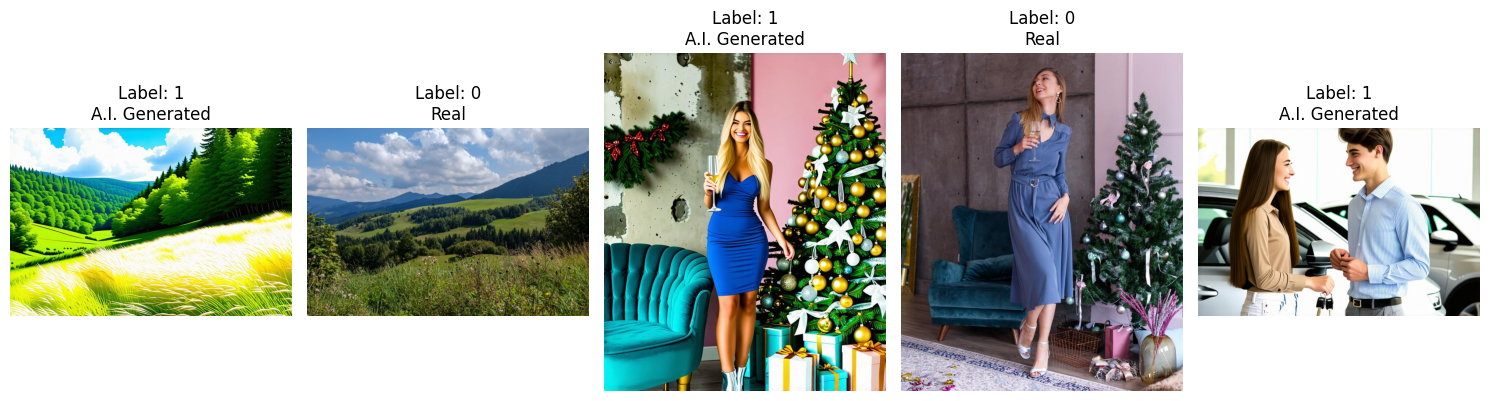

In [40]:
## label 1 -> A.I Generated Image
## Label 0 -> Real Image

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = './train.csv'
train_data = pd.read_csv(csv_path)


# Extract image paths and labels
image_paths = train_data['file_name'].values
labels = train_data['label'].values

# Function to display images with labels
def visualize_images(image_paths, labels, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Load the image
        image_path = image_paths[i+20]
        label = labels[i]
        image = Image.open(image_path)

        # Plot the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label}\n{'A.I. Generated' if label == 1 else 'Real'}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the first 5 images
visualize_images(image_paths, labels, num_images=5)

In [33]:
import warnings
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            # Attempt to load the image
            image = Image.open(image_path).convert('RGB')
        except FileNotFoundError:
            # Log a warning and return a placeholder (e.g., a blank image)
            warnings.warn(f"Image not found: {image_path}. Skipping this sample.")
            return None, None

        if self.transform:
            image = self.transform(image)

        return image, label

In [41]:
# Define transformations
# Data Augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [42]:
# Create dataset
dataset = CustomDataset(image_paths, labels, transform=transform)

# Create dataloader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

### Training

In [43]:
# Load Swinv2 visual Transformer
#image size 256 x 256
# dropout 0.2
model = timm.create_model('swinv2_small_window8_256', pretrained=True, num_classes=2,drop_rate=0.2)  # Adjust num_classes as needed
model = model.to(device)

class_weights = torch.tensor([0.5, 0.5])  # Adjust weights based on class imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 20  
checkpoint_interval = 1 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_images, batch_labels in dataloader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

    # Save model weights every 5 epochs
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'swin2_small_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Saved model weights to {checkpoint_path}')

Epoch [1/20], Loss: 0.0722
Saved model weights to ./checkpoints\swin2_small_epoch_1.pth
Epoch [2/20], Loss: 0.0459
Saved model weights to ./checkpoints\swin2_small_epoch_2.pth
Epoch [3/20], Loss: 0.0402
Saved model weights to ./checkpoints\swin2_small_epoch_3.pth
Epoch [4/20], Loss: 0.0375
Saved model weights to ./checkpoints\swin2_small_epoch_4.pth
Epoch [5/20], Loss: 0.0349
Saved model weights to ./checkpoints\swin2_small_epoch_5.pth
Epoch [6/20], Loss: 0.0333
Saved model weights to ./checkpoints\swin2_small_epoch_6.pth
Epoch [7/20], Loss: 0.0308
Saved model weights to ./checkpoints\swin2_small_epoch_7.pth
Epoch [8/20], Loss: 0.0299
Saved model weights to ./checkpoints\swin2_small_epoch_8.pth
Epoch [9/20], Loss: 0.0266
Saved model weights to ./checkpoints\swin2_small_epoch_9.pth
Epoch [10/20], Loss: 0.0267
Saved model weights to ./checkpoints\swin2_small_epoch_10.pth
Epoch [11/20], Loss: 0.0267
Saved model weights to ./checkpoints\swin2_small_epoch_11.pth
Epoch [12/20], Loss: 0.0255


In [67]:
#Resume Training

# checkpoint_path = 'checkpoints/base_vit_epoch_5.pth'  # Example path
# model.load_state_dict(torch.load(checkpoint_path))
# model.to(device)
# print(f'Loaded model weights from {checkpoint_path}')

# num_epochs = 20  
# checkpoint_interval = 5 

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0

#     for batch_images, batch_labels in dataloader:
#         batch_images = batch_images.to(device)
#         batch_labels = batch_labels.to(device)

#         # Forward pass
#         outputs = model(batch_images)
#         loss = criterion(outputs, batch_labels)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

#     # Save model weights every 5 epochs
#     if (epoch + 1) % checkpoint_interval == 0:
#         checkpoint_path = os.path.join(checkpoint_dir, f'base_vit_run2_epoch_{epoch+1}.pth')
#         torch.save(model.state_dict(), checkpoint_path)
#         print(f'Saved model weights to {checkpoint_path}')

Loaded model weights from checkpoints/base_vit_epoch_5.pth
Epoch [1/20], Loss: 0.0766
Epoch [2/20], Loss: 0.0766
Epoch [3/20], Loss: 0.0767
Epoch [4/20], Loss: 0.0766
Epoch [5/20], Loss: 0.0767
Saved model weights to ./checkpoints\base_vit_run2_epoch_5.pth
Epoch [6/20], Loss: 0.0767
Epoch [7/20], Loss: 0.0767
Epoch [8/20], Loss: 0.0767
Epoch [9/20], Loss: 0.0767
Epoch [10/20], Loss: 0.0766
Saved model weights to ./checkpoints\base_vit_run2_epoch_10.pth
Epoch [11/20], Loss: 0.0767
Epoch [12/20], Loss: 0.0766
Epoch [13/20], Loss: 0.0767
Epoch [14/20], Loss: 0.0767
Epoch [15/20], Loss: 0.0766
Saved model weights to ./checkpoints\base_vit_run2_epoch_15.pth
Epoch [16/20], Loss: 0.0767
Epoch [17/20], Loss: 0.0766
Epoch [18/20], Loss: 0.0767
Epoch [19/20], Loss: 0.0766
Epoch [20/20], Loss: 0.0766
Saved model weights to ./checkpoints\base_vit_run2_epoch_20.pth


### Testing

In [44]:
import pandas as pd

test_csv_path = './test.csv'
test_data = pd.read_csv(test_csv_path)

# Extract image paths
test_image_paths = test_data['id'].values  # Assuming the column is named 'image_path'

In [45]:
from torch.utils.data import Dataset
from PIL import Image
import warnings

class TestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('RGB')
        except FileNotFoundError:
            warnings.warn(f"Image not found: {image_path}. Skipping this sample.")
            return None, image_path  # Return the path for debugging

        if self.transform:
            image = self.transform(image)

        return image, image_path

In [46]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create test dataset
test_dataset = TestDataset(test_image_paths, transform=transform)

# Create test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [47]:
import timm
import torch

# Load the model architecture
model = timm.create_model('swinv2_small_window8_256', pretrained=False, num_classes=2)  # Adjust num_classes as needed
model = model.to(device)

# Load the trained weights
checkpoint_path = './checkpoints/swin2_small_epoch_20.pth'  # Replace with your saved weights path
model.load_state_dict(torch.load(checkpoint_path))
model.eval()  # Set the model to evaluation mode

SwinTransformerV2(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerV2Stage(
      (downsample): Identity()
      (blocks): ModuleList(
        (0): SwinTransformerV2Block(
          (attn): WindowAttention(
            (cpb_mlp): Sequential(
              (0): Linear(in_features=2, out_features=512, bias=True)
              (1): ReLU(inplace=True)
              (2): Linear(in_features=512, out_features=3, bias=False)
            )
            (qkv): Linear(in_features=96, out_features=288, bias=False)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (drop_path1): Identi

In [48]:
predictions = []
image_paths = []

with torch.no_grad():  # Disable gradient computation
    for batch_images, batch_paths in test_dataloader:
        if batch_images is None:  # Skip batches with missing images
            continue

        batch_images = batch_images.to(device)

        # Forward pass
        outputs = model(batch_images)
        _, preds = torch.max(outputs, 1)  # Get predicted class indices

        # Store predictions and image paths
        predictions.extend(preds.cpu().numpy())
        image_paths.extend(batch_paths)

In [50]:
results = pd.DataFrame({
    'image_path': image_paths,
    'prediction': predictions
})

In [28]:
submission_df = pd.DataFrame({
    'image_path': results['image_path'],
    'label': results['prediction']
})

In [51]:
submission_df.to_csv('submission_swin_v2_small.csv', index=False)
print("Submission file saved to 'submission_swin_v2_small.csv'")

Submission file saved to 'submission_swin_v2_small.csv'


### Improving the score

Submission file saved to 'submission.csv'
Sample predictions:
Image: test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg, Predicted: 0
Image: test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg, Predicted: 0
Image: test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg, Predicted: 0
Image: test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg, Predicted: 0
Image: test_data_v2/a16495c578b7494683805484ca27cf9f.jpg, Predicted: 0
Visualizing sample predictions:


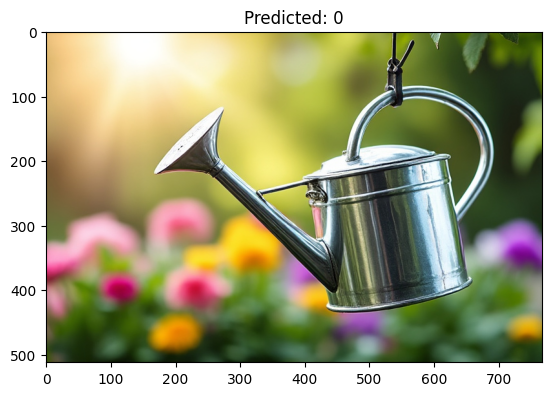

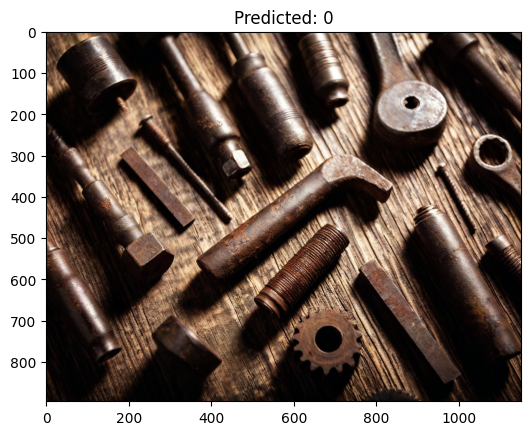

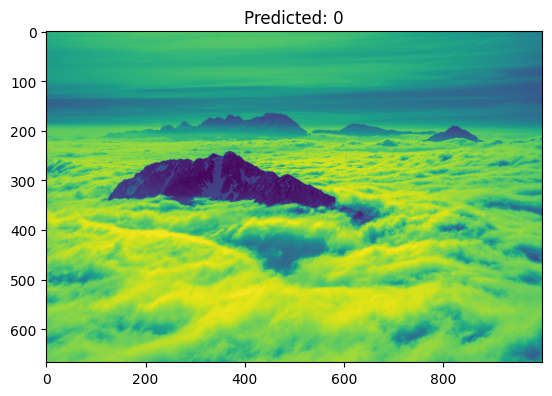

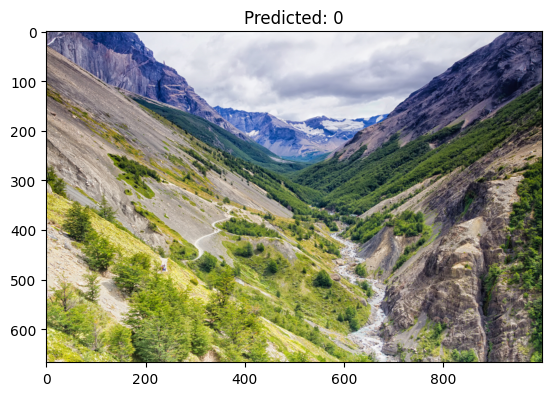

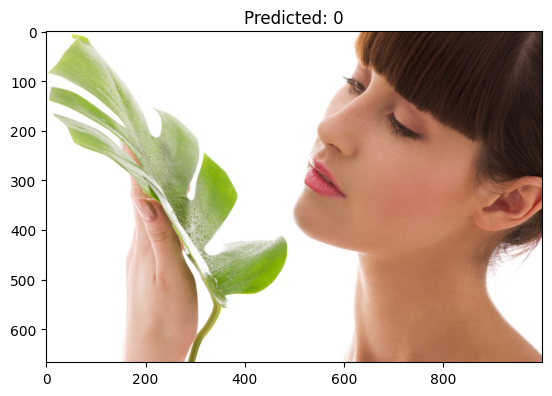

Prediction distribution:
prediction
0    5063
1     477
Name: count, dtype: int64


In [93]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# from PIL import Image
# import pandas as pd
# import timm
# import warnings
# import matplotlib.pyplot as plt

# # Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load test CSV
# test_csv_path = './test.csv'
# test_data = pd.read_csv(test_csv_path)

# # Extract image paths
# test_image_paths = test_data['id'].values

# # Define transformations (same as training)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # Define test dataset class
# class TestDataset(Dataset):
#     def __init__(self, image_paths, transform=None):
#         self.image_paths = image_paths
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image_path = self.image_paths[idx]
#         try:
#             image = Image.open(image_path).convert('RGB')
#         except FileNotFoundError:
#             warnings.warn(f"Image not found: {image_path}. Skipping this sample.")
#             return None, image_path  # Return the path for debugging

#         if self.transform:
#             image = self.transform(image)

#         return image, image_path

# # Create test dataset and dataloader
# test_dataset = TestDataset(test_image_paths, transform=transform)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# # Load the trained model
# model = timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=2)  # Adjust num_classes as needed
# model = model.to(device)

# # Load trained weights
# checkpoint_path = './checkpoints/base_vit_run2_epoch20.pth'  # Replace with your saved weights path
# model.load_state_dict(torch.load(checkpoint_path))
# model.eval()  # Set model to evaluation mode

# # Run inference
# predictions = []
# image_paths = []

# with torch.no_grad():  # Disable gradient computation
#     for batch_images, batch_paths in test_dataloader:
#         if batch_images is None:  # Skip batches with missing images
#             continue

#         batch_images = batch_images.to(device)

#         # Forward pass
#         outputs = model(batch_images)
#         _, preds = torch.max(outputs, 1)  # Get predicted class indices

#         # Store predictions and image paths
#         predictions.extend(preds.cpu().numpy())
#         image_paths.extend(batch_paths)

# # Create a DataFrame with predictions
# results = pd.DataFrame({
#     'image_path': image_paths,
#     'prediction': predictions
# })

# # Save predictions to CSV
# # submission_df = pd.DataFrame({
# #     'image_path': results['image_path'],
# #     'label': results['prediction']
# # })
# # submission_df.to_csv('submission_4.csv', index=False)
# # print("Submission file saved to 'submission.csv'")

# # Analyze predictions
# print("Sample predictions:")
# for i in range(5):  # Print first 5 predictions
#     print(f"Image: {results['image_path'][i]}, Predicted: {results['prediction'][i]}")

# # Visualize predictions
# print("Visualizing sample predictions:")
# for i in range(5):  # Display first 5 images with predictions
#     image_path = results['image_path'][i]
#     prediction = results['prediction'][i]

#     image = Image.open(image_path)
#     plt.imshow(image)
#     plt.title(f"Predicted: {prediction}")
#     plt.show()

# # Check for class distribution in predictions
# print("Prediction distribution:")
# print(results['prediction'].value_counts())

In [53]:
test_data = pd.read_csv('./submission_swin_v2_small.csv')
test_label_counts = test_data['label'].value_counts()
print(test_label_counts)

label
0    4781
1     759
Name: count, dtype: int64


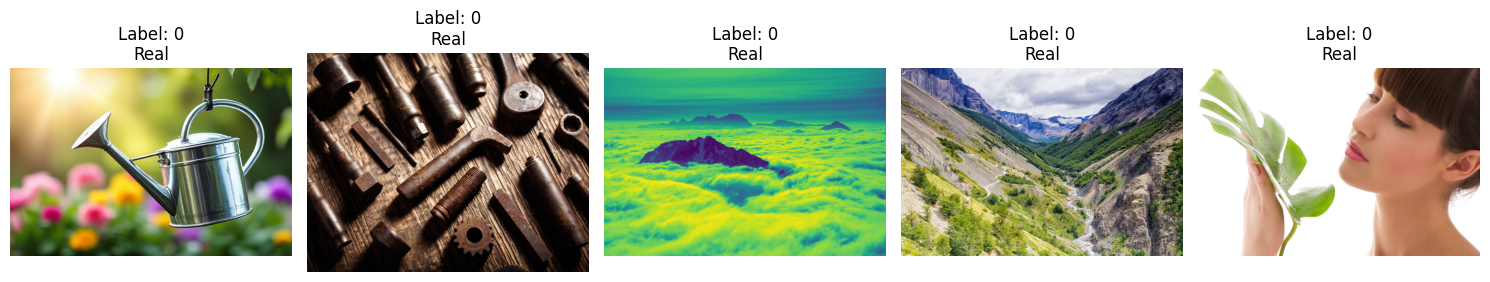

In [56]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = './submission_swin_v2_small.csv'
test_data = pd.read_csv(csv_path)

# Reverse the labels (if needed)


# Extract image paths and labels
image_paths = test_data['image_path'].values
labels = test_data['label'].values

# Function to display images with labels
def visualize_images(image_paths, labels, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Load the image
        image_path = image_paths[i]
        label = labels[i]
        image = Image.open(image_path)

        # Plot the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label}\n{'A.I. Generated' if label == 1 else 'Real'}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the first 5 images
visualize_images(image_paths, labels, num_images=5)